Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**.

---


# Imports

Install Gymnasium and dependencies to render the environments

In [ ]:
!apt-get update
!apt-get install -y swig python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python3-opengl libboost-all-dev libsdl2-dev
!pip install gymnasium==0.29.0 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1

In [1]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


# Setup Google Drive mount to store your results

In [ ]:
use_google_drive = True
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

# Download Dataset and Expert model

In [3]:
# Download training and validation datasets
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O train.zip
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O val.zip

# Unzip datasets
!unzip -q -o train.zip
!unzip -q -o val.zip

# Auxiliary Methods

The following cell contains classes and functions to provide some functionality for logging, plotting and exporting your model in the format required by the submission server.
You are free to use your own logging framework if you wish (such as tensorboard or Weights & Biases).
The logger is a very simple implementation of a CSV-file based logger.
Additionally it creates a folder for each run with subfolders for model files, logs and videos.

In [4]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")
    ax1.xaxis.grid(False)
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")
    ax4.set_xlabel('Update (Training)', color="black")
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()

"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [5]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"][np.newaxis, ...].astype(np.float32)
        action = data["action"]
        return state / 255.0, action.item()

    def append(self, states, actions):
        offset = len(self) + 1
        for i in range(len(states)):
            filename = f"{self.data_dir}/{offset+i:06}.npz"
            np.savez_compressed(filename, state=states[i], action=actions[i].astype(np.int32))
            self.files.append(filename)

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [6]:
# Action Statistics
dataset = DemonstrationDataset("train")
print("Number of samples: {}".format(len(dataset)))

Number of samples: 49538


Action: do nothing


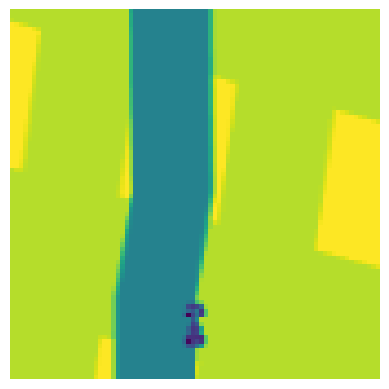

In [7]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
print(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [8]:
# release memory
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, num_actions):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.fc3 = nn.Linear(32 * 19 * 19, 256)
        self.fc4 = nn.Linear(256, num_actions)
        self._initialize_weights()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x




    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)


# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [22]:
# choose the batchsize for training
batch_size = 256
num_epochs = 5

# Datasets
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
logger = Logger("logdir")
print("Saving state to {}".format(logger.basepath))

# Network
model = PolicyNetwork(num_actions=5)
model = model.to(device)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.002, alpha=0.9)

criterion = nn.CrossEntropyLoss()

def train(model,optimizer, loss_fn, train_loader, device):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (states,actions) in enumerate(train_loader):
        #state is an input and cation is an output:
        states,actions = states.to(device),actions.to(device)

        # Zero your gradients for every batch:
        optimizer.zero_grad()

        #prediction for a batch:
        pred_actions = model(states)

        # Compute the loss and its gradients
        loss = loss_fn(pred_actions, actions)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        #metrics
        train_loss += loss.item()
        _, predicted = pred_actions.max(1)
        total += actions.size(0)
        correct += predicted.eq(actions).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / total
    return train_loss, accuracy

def evaluate(model, loss_fn, val_loader, device):

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for states, actions in val_loader:
            states,actions = states.to(device),actions.to(device)
            #prediction for a batch:
            pred_actions = model(states)

            # Compute the loss and its gradients
            loss = loss_fn(pred_actions, actions)

            #metrics
            val_loss += loss.item()
            _, predicted = pred_actions.max(1)
            total += actions.size(0)
            correct += predicted.eq(actions).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / total
    return val_loss, accuracy


for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, device)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader, device)
    print('Epoch:', epoch+1,
          'Train Loss:', train_loss, 'Train Accuracy:', train_accuracy,
          'Val Loss:', val_loss, 'Val Accuracy:', val_accuracy)


# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
save_as_onnx(model, sample_state, logger.onnx_file)

Saving state to logdir/2024-04-15T22-20-54
Trainable Parameters: 2963653
Epoch: 1 Train Loss: 0.002596970894239735 Train Accuracy: 77.19280502781189 Val Loss: 0.003097448995083627 Val Accuracy: 70.74434341298372
Epoch: 2 Train Loss: 0.0023845045098781 Train Accuracy: 79.43075922849093 Val Loss: 0.003128790904563586 Val Accuracy: 71.20955804609854
Epoch: 3 Train Loss: 0.0023727384522446385 Train Accuracy: 79.48277107563389 Val Loss: 0.0031045025159803954 Val Accuracy: 71.31528864453372
Epoch: 4 Train Loss: 0.002355358789725463 Train Accuracy: 79.46109947265766 Val Loss: 0.0030504271000478755 Val Accuracy: 71.26242334531614
Epoch: 5 Train Loss: 0.0023299374591061587 Train Accuracy: 79.672036408293 Val Loss: 0.003063148683613313 Val Accuracy: 71.10382744766335


# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

In [11]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]


class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames


class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):
        with torch.no_grad():
            state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            return probs.sample().cpu().numpy()[0]


def make_env(seed, capture_video=True):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir)

    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = RecordState(env, reset_clean=True)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent, show_progress=True, capture_video=True, seed=None):
    env = make_env(seed=seed, capture_video=capture_video)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")

    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))
    env.close()

    if show_progress:
        progress.close()
    if capture_video:
        show_video(logger.video_dir)

    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [12]:
train_policy = Agent(model, device)
score = run_episode(train_policy, show_progress=True, capture_video=True);
print(f"Score: {score:.2f}")

Score: 779.10: : 999it [00:34, 24.77it/s]

Moviepy - Building video /tf/jku/logdir/2024-04-15T16-53-14/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-04-15T16-53-14/videos/rl-video-episode-0.mp4




t:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1001 [00:03<00:00, 283.47it/s, now=None]
Score: 782.56: : 1000it [00:37, 26.36it/s]                                                                                                                                          

Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-04-15T16-53-14/videos/rl-video-episode-0.mp4


Score: 782.56


Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [ ]:
train_policy = Agent(model, device)
n_eval_episodes = 30
scores = []
avg_scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    score = run_episode(train_policy, show_progress=False, capture_video=False);
    scores.append(score)
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [14]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))
expert_model = expert_model.to(device)
# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad = False

expert_policy = Agent(expert_model, device)

/usr/local/lib/python3.11/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

In [15]:
import numpy as np

def dagger(env, train_policy, expert_policy, beta=1.0):
    """
    Performs one iteration of DAgger and updates the dataset with new states and labels

    Args:
    env: gym environment
    train_policy: the policy to train
    expert_policy: the expert policy
    dataset: list containing the dataset, each element is a tuple (states, labels)
    beta: float, probability of selecting expert action

    Returns:
    Updated dataset
    """

    # initialize list of states and actions
    states = []
    labels = []
    score = 0
    T = 150 #length of trajectory

    # get initial state from environment
    state , _ = env.reset()
    # loop until episode finishes
    done = False

    # 1. Choose a policy (sample according to beta)
    if np.random.uniform() < beta:
        policy_name = 'expert_policy'
    else:
        policy_name = 'train_policy'

    #2. Sample from trajectory of length T
    
    for i in range(T):
        if done:
            break
        
        # choose an action according to the beta probability
        if policy_name == 'expert_policy':
            action = expert_policy.select_action(state)
        else:
            action = train_policy.select_action(np.expand_dims(state[-1], 0))

        # take the action in the environment
        next_state, reward, done, truncated, _ = env.step(action)
        #print('Reward:',reward)
        score += reward
        done = done or truncated

        # label state by expert policy
        state = np.array(state)
        expert_state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
        logits = expert_policy.model(expert_state)
        _, label = logits.max(1)
        # Record the state and action
        state = np.expand_dims(state[-1], 0)
        if reward > 0:
            states.append(np.squeeze(state,axis = 0))
            labels.append(label.item())

        # update state for the next iteration
        state = next_state

    # convert states list to numpy array
    states = np.array(states)
    # convert labels list to numpy array
    labels = np.array(labels)

    #dataset.append(states, labels)

    return states, labels, score



Put everything together now.
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

Saving state to logdir_dagger/2024-04-15T22-22-29
Length of aggregated dataset:  71113
Epoch: 1 Train Loss: 0.0024999800805003657 Train Accuracy: 78.54963227539268 Val Loss: 0.0031060008940673525 Val Accuracy: 70.57517445548741
Epoch: 2 Train Loss: 0.0023364696929916566 Train Accuracy: 79.98537538846624 Val Loss: 0.0031029505958061034 Val Accuracy: 70.82892789173187
Epoch: 3 Train Loss: 0.002326516416765407 Train Accuracy: 80.00646857817839 Val Loss: 0.0030817617684898934 Val Accuracy: 71.20955804609854
Epoch: 4 Train Loss: 0.0023017184932453884 Train Accuracy: 80.16958924528568 Val Loss: 0.0030798590329465265 Val Accuracy: 71.06153520828929
Epoch: 5 Train Loss: 0.002284992503578081 Train Accuracy: 80.21740047529987 Val Loss: 0.0031390687607135803 Val Accuracy: 70.96637766969761
Length of aggregated dataset:  73072
Epoch: 1 Train Loss: 0.0024864293360817163 Train Accuracy: 78.70045982045106 Val Loss: 0.003131767588756785 Val Accuracy: 70.72319729329668
Epoch: 2 Train Loss: 0.0022942749

In [ ]:
# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
logger = Logger("logdir_dagger")
print("Saving state to {}".format(logger.basepath))

# start environment
env = make_env(seed=42, capture_video=False)

number_models = 12
num_epochs = 5
num_trajectories = 200 #number of trajectories to sample in DAgger

# Datasets
train_dataset = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

beta = 0.90
gamma = 0.9

scores = []
all_states = []
all_labels = []

for i in range(number_models):
    # Network
    model = PolicyNetwork(num_actions=5)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()


    #sample T trajectories amd aggregate datasets:
    for j in range(num_trajectories):
        states, labels, score = dagger(env, train_policy, expert_policy, beta=beta)
        scores.append(score)
        all_states.append(states)
        all_labels.append(labels)
        
    threshold_score = np.percentile(scores, 70)
    for idx, score in enumerate(scores):
        if score >= threshold_score:
            train_dataset.append(all_states[idx], all_labels[idx])

    all_states = []
    all_labels = []
    scores = []
    beta = beta * gamma
    print('Length of aggregated dataset: ',len(train_dataset))

    # Training
    for epoch in range(num_epochs):
        #Train on aggregated dataset
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, device)
        #validate the result
        val_loss, val_accuracy = evaluate(model, criterion, val_loader, device)
        print('Epoch:', epoch+1,
            'Train Loss:', train_loss, 'Train Accuracy:', train_accuracy,
            'Val Loss:', val_loss, 'Val Accuracy:', val_accuracy)

    print('='*100)
    #update train policy
    train_policy = Agent(model,device)
    save_as_onnx(model, sample_state, logger.onnx_file)

env.close()



In [17]:
# Load expert
train_policy = ConvertModel(onnx.load("model.onnx"))
train_policy = train_policy.to(device)
# Freeze expert weights
for p in train_policy.parameters():
    p.requires_grad = False

train_policy = Agent(train_policy, device)

In [18]:
n_eval_episodes = 30
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    print("Score: %d" % scores[-1])
print("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode:   3%|████▌                                                                                                                                  | 1/30 [00:07<03:48,  7.87s/it]

Score: 596


Episode:   7%|█████████                                                                                                                              | 2/30 [00:15<03:39,  7.83s/it]

Score: 710


Episode:  10%|█████████████▌                                                                                                                         | 3/30 [00:23<03:27,  7.68s/it]

Score: 865


Episode:  13%|██████████████████                                                                                                                     | 4/30 [00:30<03:16,  7.56s/it]

Score: 720


Episode:  17%|██████████████████████▌                                                                                                                | 5/30 [00:37<03:07,  7.50s/it]

Score: 863


Episode:  20%|███████████████████████████                                                                                                            | 6/30 [00:45<02:59,  7.46s/it]

Score: 628


Episode:  23%|███████████████████████████████▌                                                                                                       | 7/30 [00:52<02:51,  7.47s/it]

Score: 822


Episode:  27%|████████████████████████████████████                                                                                                   | 8/30 [01:00<02:45,  7.50s/it]

Score: 889


Episode:  30%|████████████████████████████████████████▌                                                                                              | 9/30 [01:08<02:38,  7.54s/it]

Score: 762


Episode:  33%|████████████████████████████████████████████▋                                                                                         | 10/30 [01:16<02:33,  7.69s/it]

Score: 843


Episode:  37%|█████████████████████████████████████████████████▏                                                                                    | 11/30 [01:23<02:26,  7.70s/it]

Score: 827


Episode:  40%|█████████████████████████████████████████████████████▌                                                                                | 12/30 [01:31<02:17,  7.64s/it]

Score: 569


Episode:  43%|██████████████████████████████████████████████████████████                                                                            | 13/30 [01:38<02:09,  7.61s/it]

Score: 748


Episode:  47%|██████████████████████████████████████████████████████████████▌                                                                       | 14/30 [01:46<02:03,  7.75s/it]

Score: 658


Episode:  50%|███████████████████████████████████████████████████████████████████                                                                   | 15/30 [01:54<01:55,  7.68s/it]

Score: 612


Episode:  53%|███████████████████████████████████████████████████████████████████████▍                                                              | 16/30 [02:01<01:46,  7.64s/it]

Score: 842


Episode:  57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 17/30 [02:09<01:38,  7.59s/it]

Score: 854


Episode:  60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 18/30 [02:16<01:30,  7.56s/it]

Score: 528


Episode:  63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 19/30 [02:24<01:22,  7.49s/it]

Score: 892


Episode:  67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 20/30 [02:32<01:15,  7.60s/it]

Score: 411


Episode:  70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 21/30 [02:39<01:08,  7.57s/it]

Score: 441


Episode:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 22/30 [02:46<00:59,  7.45s/it]

Score: 904


Episode:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 23/30 [02:53<00:50,  7.19s/it]

Score: 913


Episode:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 24/30 [03:00<00:43,  7.22s/it]

Score: 872


Episode:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 25/30 [03:08<00:36,  7.35s/it]

Score: 696


Episode:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 26/30 [03:16<00:30,  7.54s/it]

Score: 617


Episode:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 27/30 [03:24<00:22,  7.61s/it]

Score: 720


Episode:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 28/30 [03:31<00:15,  7.50s/it]

Score: 441


Episode:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 29/30 [03:39<00:07,  7.58s/it]

Score: 421


Episode: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:46<00:00,  7.55s/it]

Score: 766
Mean Score: 714.80 (Std: 154.71)
